# Foraging toolkit demo - follower birds

In this notebook we use the foraging toolkit to simulate agents that move toward other agents. 

_The users are advised to be familiarized with the `random_foragers.ipynb` demo, which contains detailed explanation of the various commands._

The "follower" behaviour is in some sense opposite of _hungry agents_ which care only about food location (see `hungry_foragers.ipynb` demo notebook).

In [1]:
# importing packages. See https://github.com/BasisResearch/collab-creatures for repo setup
import logging
import os
import random
import time

import dill
import matplotlib.pyplot as plt
import numpy as np
import pyro

import collab2.foraging.toolkit as ft
from collab2.foraging import random_hungry_followers as rhf

logging.basicConfig(format="%(message)s", level=logging.INFO)

# users can ignore smoke_test -- it's for automatic testing on GitHub, to make sure the notebook runs on future updates to the repository
smoke_test = "CI" in os.environ
num_frames = 5 if smoke_test else 50
num_svi_iters = 10 if smoke_test else 1000
num_samples = 10 if smoke_test else 1000

notebook_starts = time.time()

## Simulation


**Simulation of following foragers**
Note that rewards have impact on agents' positions and therefore reward and trace updates are required at every step.
- **Initialization**
    - Initialize the grid with a specified grid size
    - Randomly place `num_rewards` rewards
    - Normalize the probabilities for forager step size
- **Forward Simulation**
    - For each frame:
        - Update visibility for foragers
        - Compute proximity scores for all foragers, with local maxima at other foragers' locations and exponential decay.
        - For each forager:
            - Weight proximity scores with the forager's visibility scores
            - Sort accessible points by the above weighted score
            - Move forager to a randomly chosen position from among top 10 ranking points above

- **Update Rewards**
    - At each frame, remove a reward if a forager is next to it, starting from that frame onward.


2024-09-28 11:58:14,664 - Generating frame 10/50 
2024-09-28 11:58:14,794 - Generating frame 20/50 
2024-09-28 11:58:14,933 - Generating frame 30/50 
2024-09-28 11:58:15,082 - Generating frame 40/50 


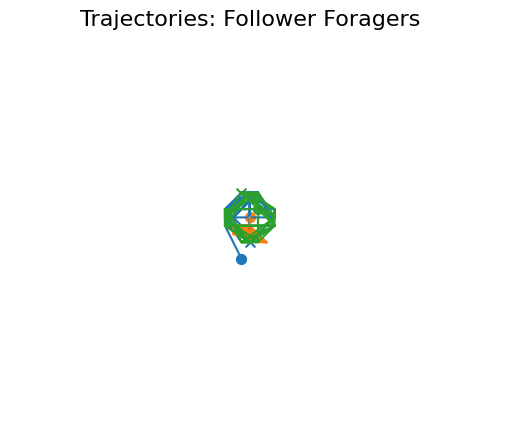

In [2]:
random.seed(23)
np.random.seed(23)

# create a new empty simulation (a starting point for the actual simulation)
grid_size = 60
follower_sim = rhf.Foragers(
    grid_size=grid_size,
    num_foragers=3,
    num_frames=num_frames,
    num_rewards=30,
    grab_range=3,
)

# run the simulation: this places the rewards on the grid
follower_sim()

# add the followers to the simulation and run simulation forward
follower_sim = rhf.add_follower_foragers(
    follower_sim,
    num_follower_foragers=3,
    visibility_range=6,
    getting_worse=0.5,
    optimal=3,
)

# display(follower_sim.foragersDF)
plot = ft.plot_trajectories(follower_sim.foragersDF, "Follower Foragers")
plot.xlim(0, grid_size)
plt.ylim(0, grid_size)
plot.show()

Unsurprisingly, all the foragers stay close to each other and do not explore the environment.

In [3]:
ft.animate_foragers(
    follower_sim, width=600, height=400, plot_rewards=True, point_size=6
)

## Derived quantities

In [4]:
# We'll use `proximity`, `food` and `access` predictors

local_windows_kwargs = {
    "window_size": 10,
    "sampling_fraction": 1,
    "skip_incomplete_frames": False,
}

predictor_kwargs = {
    "proximity": {
        "interaction_length": follower_sim.grid_size / 3,
        "interaction_constraint": None,
        "interaction_constraint_params": {},
        "repulsion_radius": 1.5,
        "optimal_distance": 4,
        "proximity_decay": 1,
    },
    "food": {
        "decay_factor": 0.5,
    },
    "access": {
        "decay_factor": 0.2,
    },
}

score_kwargs = {
    "nextStep_linear": {"nonlinearity_exponent": 1},
    "nextStep_sublinear": {"nonlinearity_exponent": 0.5},
}

derivedDF_hungry = ft.derive_predictors_and_scores(
    follower_sim,
    local_windows_kwargs,
    predictor_kwargs=predictor_kwargs,
    score_kwargs=score_kwargs,
    dropna=True,
    add_scaled_values=True,
)

# display(derivedDF_hungry)

2024-09-28 11:58:16,263 - proximity completed in 0.24 seconds.
2024-09-28 11:58:17,162 - food completed in 0.90 seconds.
2024-09-28 11:58:17,235 - access completed in 0.07 seconds.
2024-09-28 11:58:17,289 - nextStep_linear completed in 0.05 seconds.
2024-09-28 11:58:17,400 - nextStep_sublinear completed in 0.11 seconds.
/Users/dima/git/collab-creatures/collab2/foraging/toolkit/derive.py:56: UserWarning:


                      Dropped 951/47550 frames from `derivedDF` due to NaN values.
                      Missing values can arise when computations depend on next/previous step positions
                      that are unavailable. See documentation of the corresponding predictor/score generating
                      functions for more information.
                      



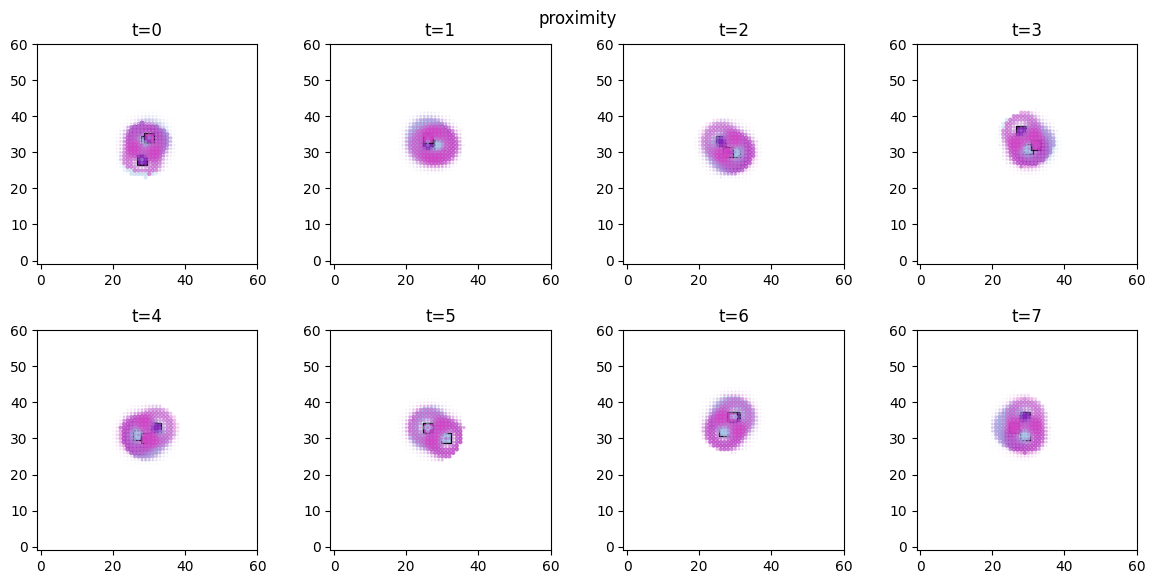

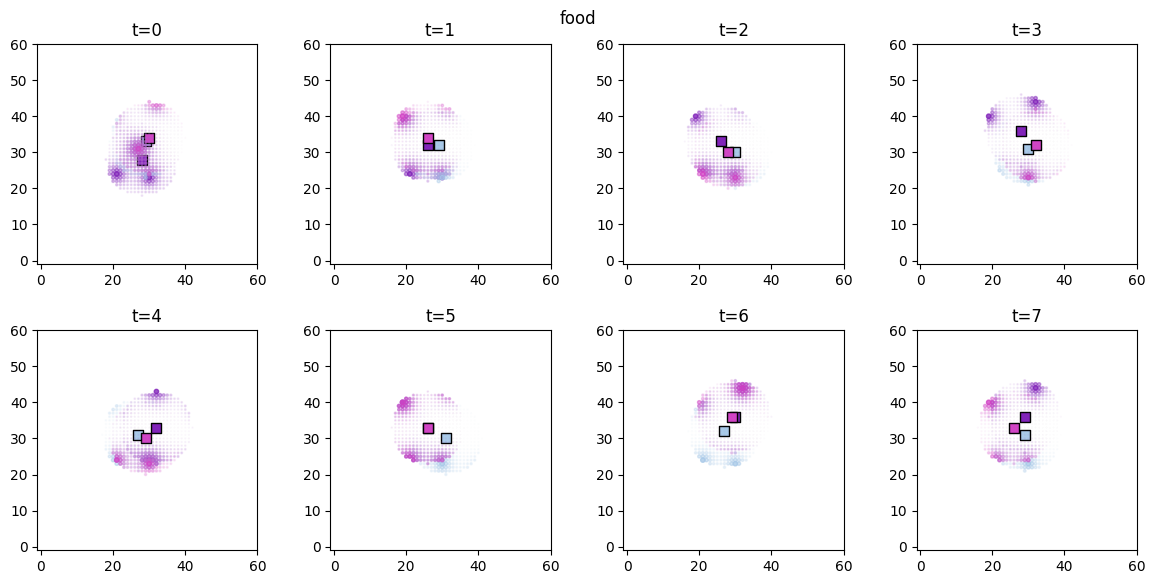

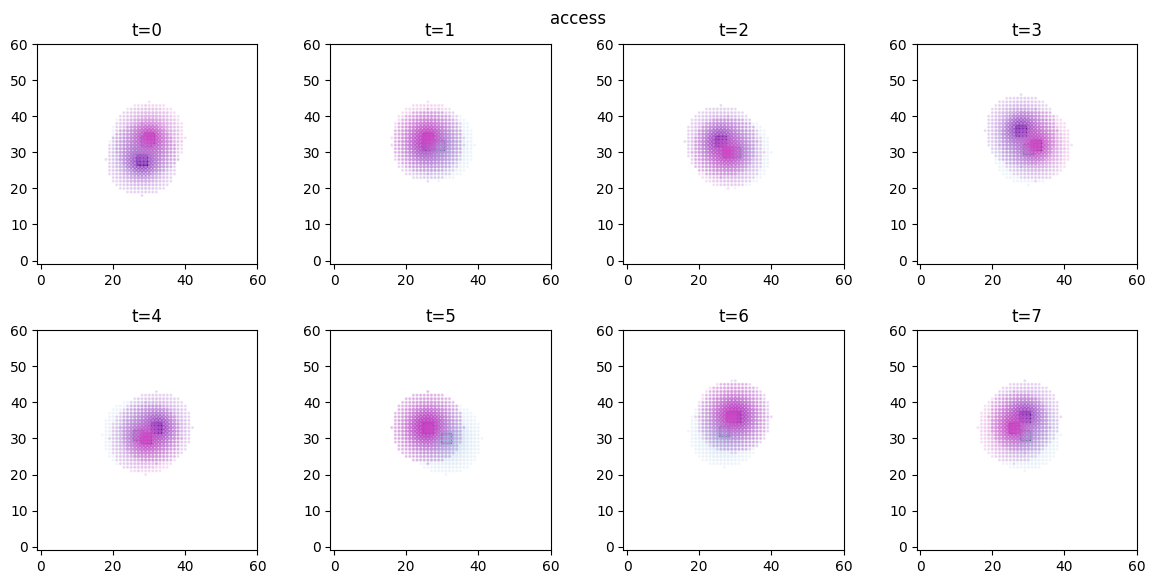

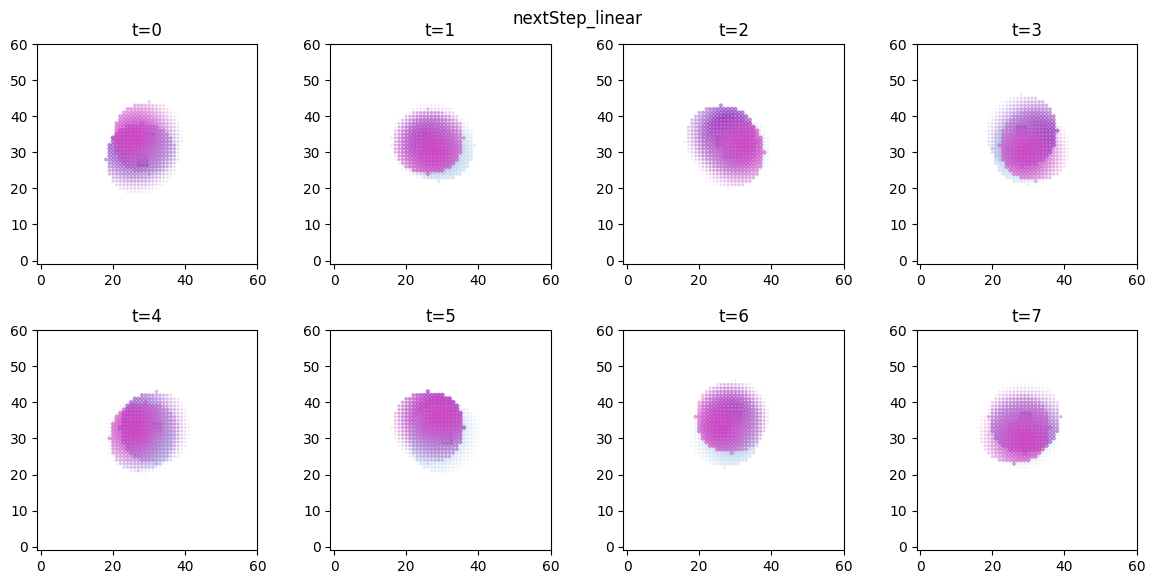

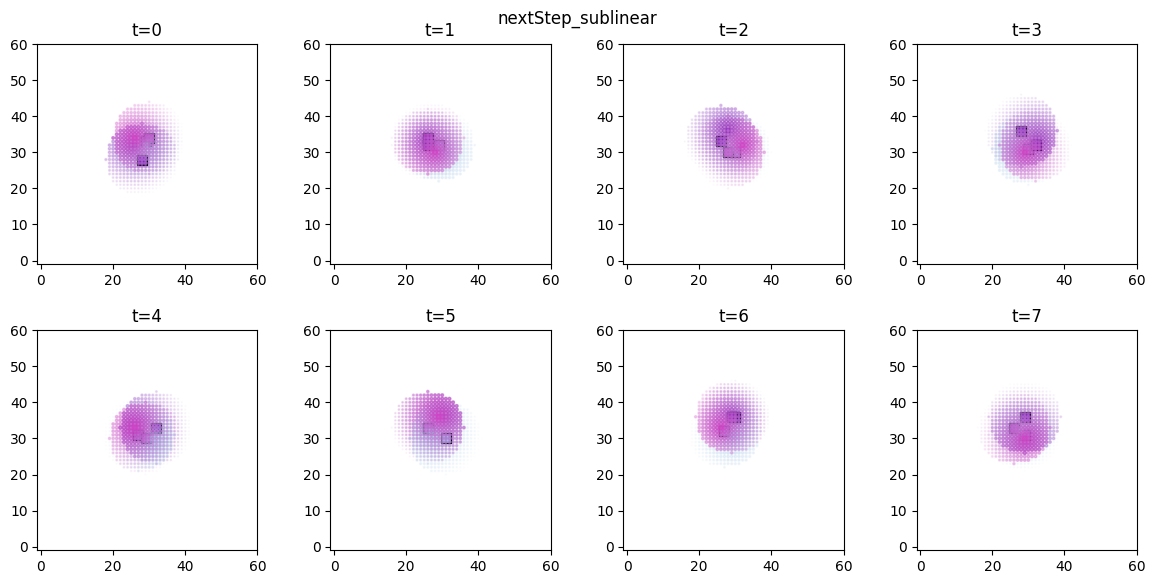

In [5]:
# visualize the spatial distributions of the derived quantities for each forager

for derived_quantity_name in follower_sim.derived_quantities.keys():
    ft.plot_predictor(
        follower_sim.foragers,
        follower_sim.derived_quantities[derived_quantity_name],
        predictor_name=derived_quantity_name,
        time=range(min(8, num_frames)),
        grid_size=grid_size,
        size_multiplier=10,
        random_state=99,
        forager_position_indices=[0, 1, 2],
        forager_predictor_indices=[0, 1, 2],
    )
    plt.suptitle(derived_quantity_name)
    plt.show()

## Inference

2024-09-28 12:31:01,234 - Starting SVI inference with 1500 iterations.


[iteration 0001] loss: 166427.0469
[iteration 0050] loss: 122494.3438
[iteration 0100] loss: 117118.7109
[iteration 0150] loss: 114251.3359
[iteration 0200] loss: 111254.7344
[iteration 0250] loss: 110304.2969
[iteration 0300] loss: 109692.2344
[iteration 0350] loss: 109268.6016
[iteration 0400] loss: 110599.8828
[iteration 0450] loss: 109626.6875
[iteration 0500] loss: 109172.8828
[iteration 0550] loss: 109953.1328
[iteration 0600] loss: 110054.2031
[iteration 0650] loss: 109139.2969
[iteration 0700] loss: 109464.8828
[iteration 0750] loss: 109077.9922
[iteration 0800] loss: 109253.1328
[iteration 0850] loss: 109483.6016
[iteration 0900] loss: 110423.7188
[iteration 0950] loss: 109256.3359
[iteration 1000] loss: 109170.0312
[iteration 1050] loss: 109091.0938
[iteration 1100] loss: 109227.8125
[iteration 1150] loss: 109344.5312
[iteration 1200] loss: 109533.4766
[iteration 1250] loss: 109152.1562
[iteration 1300] loss: 109174.0938
[iteration 1350] loss: 109353.9062
[iteration 1400] los

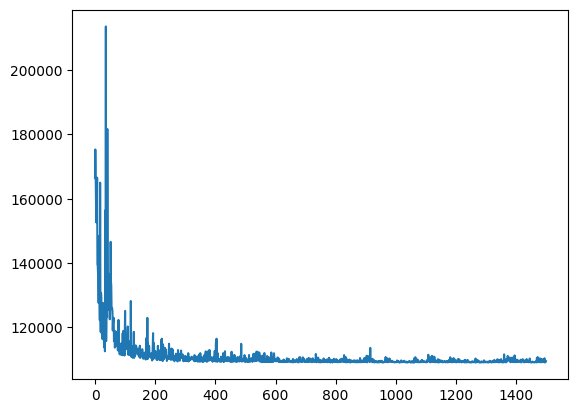

2024-09-28 12:31:06,436 - SVI inference completed in 5.20 seconds.


dict_keys(['bias_continuous_proximity_scaled_nextStep_sublinear', 'weight_continuous_proximity_scaled_nextStep_sublinear', 'bias_continuous_food_scaled_nextStep_sublinear', 'weight_continuous_food_scaled_nextStep_sublinear', 'bias_continuous_access_scaled_nextStep_sublinear', 'weight_continuous_access_scaled_nextStep_sublinear', 'bias_continuous_proximity_scaled_nextStep_sublinear_sigma', 'weight_continuous_proximity_scaled_nextStep_sublinear_sigma', 'bias_continuous_food_scaled_nextStep_sublinear_sigma', 'weight_continuous_food_scaled_nextStep_sublinear_sigma', 'bias_continuous_access_scaled_nextStep_sublinear_sigma', 'weight_continuous_access_scaled_nextStep_sublinear_sigma', 'proximity_scaled', 'food_scaled', 'access_scaled', 'nextStep_sublinear'])
['weight_continuous_proximity_scaled_nextStep_sublinear', 'weight_continuous_food_scaled_nextStep_sublinear', 'weight_continuous_access_scaled_nextStep_sublinear']
Coefficient marginals:
Site: weight_continuous_proximity_scaled_nextStep_s

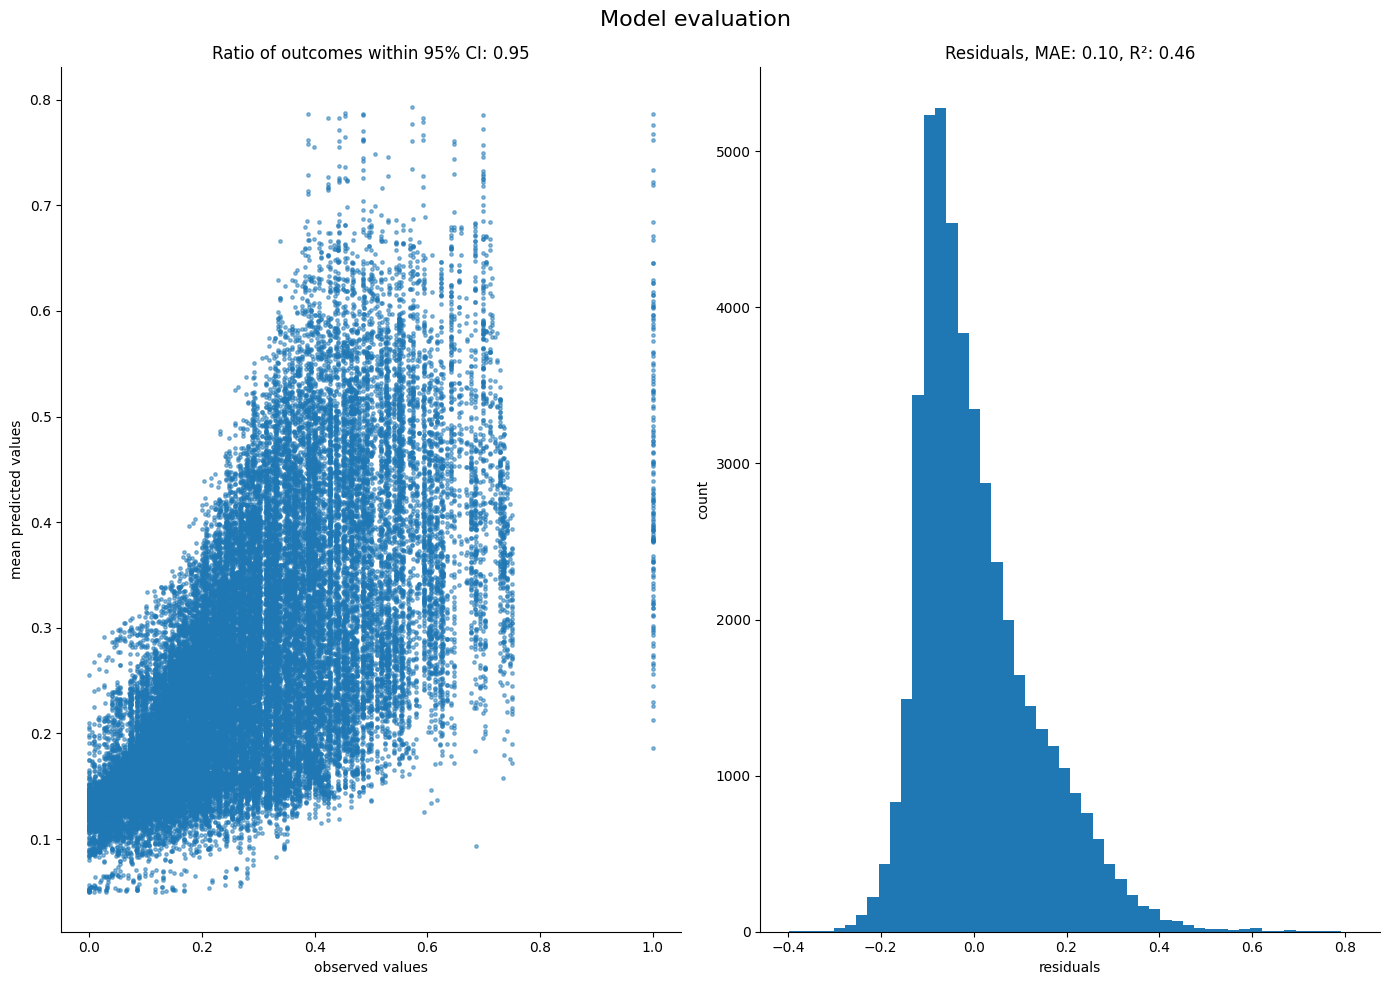

In [7]:
# prepare the training data

predictors = ["proximity_scaled", "food_scaled", "access_scaled"]
outcome_vars = ["nextStep_sublinear"]


predictor_tensors_follower, outcome_tensor_follower = ft.prep_data_for_inference(
    follower_sim, predictors, outcome_vars
)

# construct Pyro model
model_sigmavar_follower = ft.HeteroskedasticLinear(
    predictor_tensors_follower, outcome_tensor_follower
)
pyro.render_model(
    model_sigmavar_follower,
    model_args=(predictor_tensors_follower, outcome_tensor_follower),
    # render_deterministic=True, # requires pyro .1.9.1
)

# runs SVI to approximate the posterior and samples from it
results_follower = ft.get_samples(
    model=model_sigmavar_follower,
    predictors=predictor_tensors_follower,
    outcome=outcome_tensor_follower,
    num_svi_iters=1500,
    num_samples=1000,
)

selected_sites = [
    key
    for key in results_follower["samples"].keys()
    if key.startswith("weight") and not key.endswith("sigma")
]
selected_samples = {key: results_follower["samples"][key] for key in selected_sites}

ft.plot_coefs(
    selected_samples, "Follower foragers", nbins=120, ann_start_y=160, ann_break_y=50
)

# save the samples for future use
with open(os.path.join("sim_data", "follower_foragers_samples.dill"), "wb") as f:
    dill.dump(selected_samples, f)

ft.evaluate_performance(
    model=model_sigmavar_follower,
    guide=results_follower["guide"],
    predictors=predictor_tensors_follower,
    outcome=outcome_tensor_follower,
    num_samples=1000,
)

As expected, both `access` and `proximity` are now significant in explaining the agent movements, while `food` has no effect.